In [26]:
import sklearn 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d
from sklearn.metrics import pairwise_distances_argmin
#you can use Python’s imaging library (PIL)
from PIL import Image
from IPython.display import display
import scipy.cluster.hierarchy as sch #you only for sch.dendrogram


1. generating data

In [27]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=4)


name = "cropped.jpg"
img = Image.open(name)
img = img.convert('RGB')
rgb = np.array(img).reshape((-1,3))


2. Plot using MatplotLib

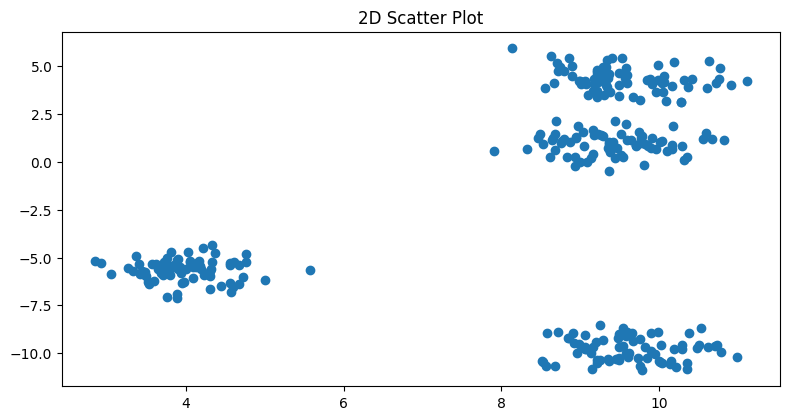

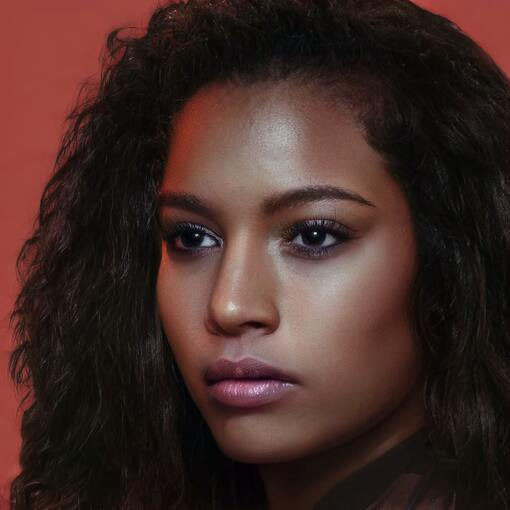

In [28]:
fig = plt.figure(figsize=(8, 8)) 
ax = fig.add_subplot(211) 
ax.scatter(X[:, 0], X[:, 1])
ax.set_title('2D Scatter Plot')



plt.tight_layout() 
plt.show()

display(img)

3. and 6. Implementing K-means and K-means++ 

In [29]:

class Kmeans():
    def __init__(self, k, seed=None) -> None:
        self.k = k
        self.centroids = None
        self.seed = seed
        if seed != None:
            np.random.seed(seed)


    def initilize_centroids(self, points):
        rand_i = np.random.choice(points.shape[0], size=self.k, replace=False)
        self.centroids = points[rand_i]

    def update_centroids(self,points, centroids):
        new_y = pairwise_distances_argmin(points, centroids)
        new_centroids = []

        # calculating new centroids
        for i in range(self.k):
            cluster = points[new_y == i]
            if len(cluster) == 0:
                # check for empty cluster, and randomlly assign cluster if so
                new_centroid = points[np.random.choice(points.shape[0])]
            else:
                new_centroid = cluster.mean(axis=0)
            new_centroids.append(new_centroid)

        new_centroids = np.array(new_centroids)
        return new_centroids

    def fit(self, points):
        self.initilize_centroids(points)
        new_centroids = self.centroids
        while True:
            new_centroids = self.update_centroids(points, self.centroids)
            if (np.sum(abs(new_centroids-self.centroids)) < 0.05):
                self.centroids = new_centroids
                break
            self.centroids = new_centroids
            
    def plot(self,points):
        dim = np.shape(points)[1]
        if dim == 2:
            fig = plt.figure()
            ax = fig.add_subplot()
            ax.scatter(points[:,0],points[:, 1])
            ax.scatter(self.centroids[:, 0], self.centroids[:, 1], color='red', marker='.', s=100)
        elif dim == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111,projection='3d')
            ax.scatter(points[:,0],points[:, 1], points[:,2], alpha=0.1)
            ax.scatter(self.centroids[:, 0], self.centroids[:, 1], self.centroids[:,2],color='red', marker='.', s=100)

        plt.show()

    def return_centers(self):
        return self.centroids


class KmeansPP(Kmeans):
    def __init__(self, k, seed=None) -> None:
        super().__init__(k, seed)

    def initilize_centroids(self, points):
        rand_i = np.random.choice(points.shape[0])
        centroid = points[rand_i]
        points = np.delete(points, rand_i, axis=0)
        centroids = [centroid]

        for _ in range(1, self.k):
            distances = np.min([np.sum((points - center)**2, axis=1) for center in centroids], axis=0)
            probs = distances/np.sum(distances)
            cent_i = np.random.choice(probs.shape[0], 1, p=probs)[0]

            #cent_i = np.argmax(distances) 

            centroids.append(points[cent_i])
            points = np.delete(points, cent_i, axis=0)

        self.centroids = np.array(centroids)


def display_image(rgb, centroids):
    new_list = []
    closest = pairwise_distances_argmin(rgb,centroids)
    for i in range(len(rgb)):
        index = closest[i]
        new_list.append(centroids[index])

    pic = np.array(new_list)
    pic = pic.astype(np.uint8)
    pic = pic.reshape(np.shape(img))
    pic = Image.fromarray(pic)
    display(pic)

4.  Fit the model using Kmeans on default seed and plot

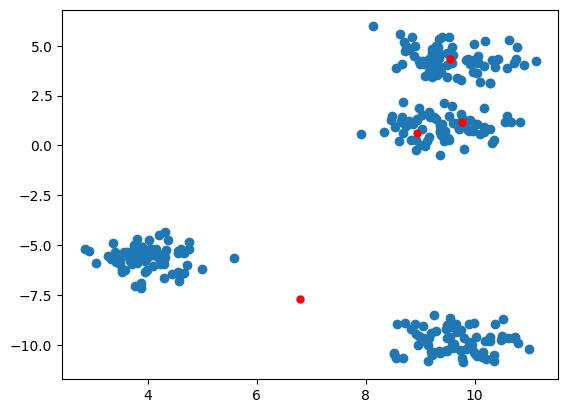

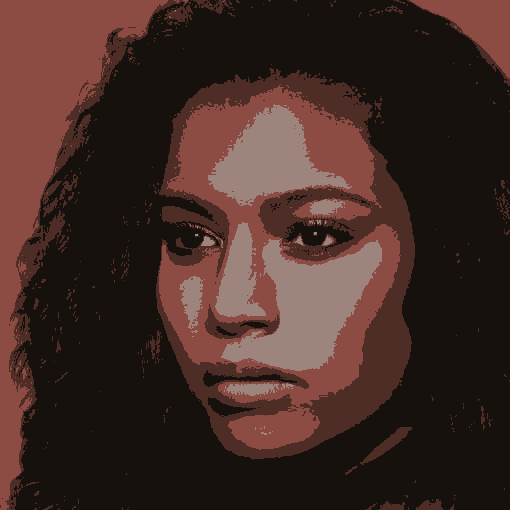

In [30]:
num_centroids = 4
a = Kmeans(num_centroids)
a.fit(X)
a.plot(X)



a = Kmeans(num_centroids)
a.fit(rgb)
display_image(rgb, a.return_centers())

5. Fit the model using KMeans on seed=2 and plot

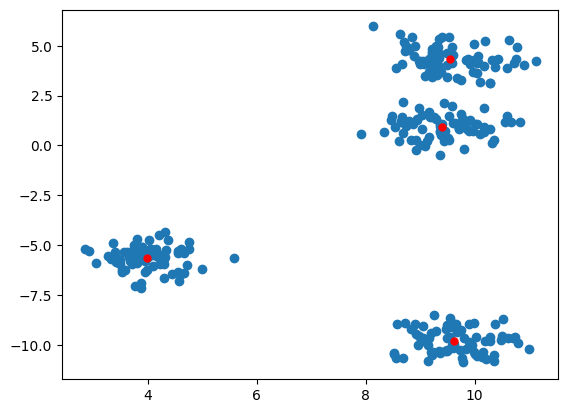

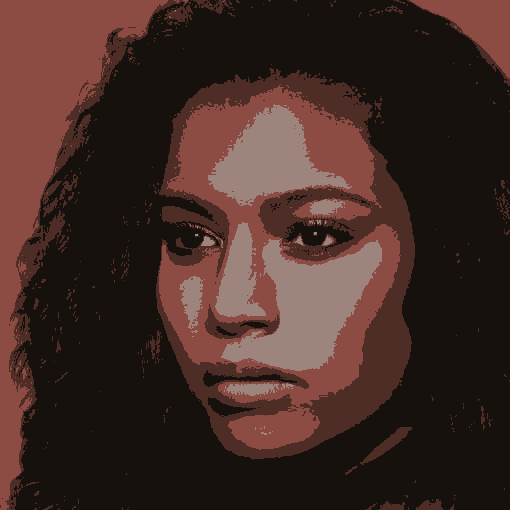

In [31]:
num_centroids = 4
a = Kmeans(num_centroids,2)
a.fit(X)
a.plot(X)



a = Kmeans(num_centroids,2)
a.fit(rgb)
display_image(rgb, a.return_centers())

7. Fit the model using Kmean++ using default seed and plot

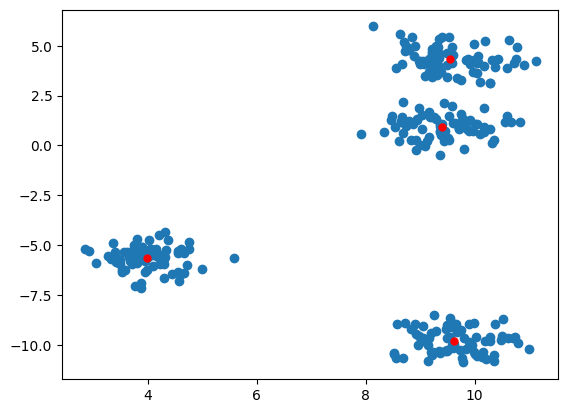

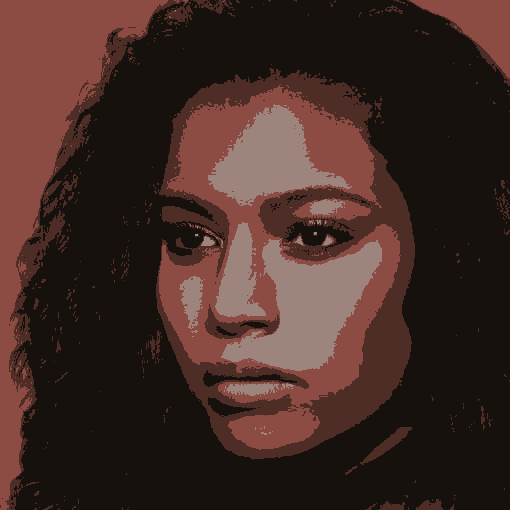

In [32]:
num_centroids = 4
a = KmeansPP(num_centroids)
a.fit(X)
a.plot(X)



a = KmeansPP(num_centroids)
a.fit(rgb)
display_image(rgb, a.return_centers())

8. Fit the model using Kmean++ using seed=2 and plot

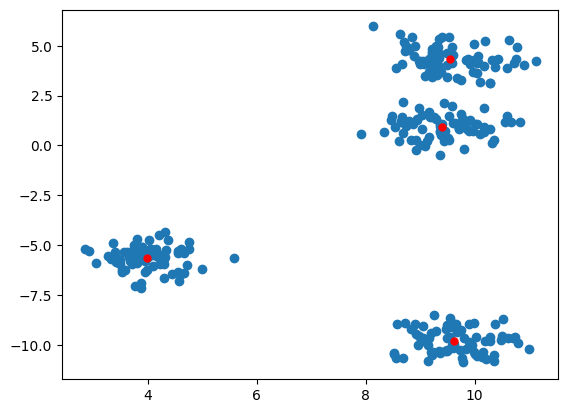

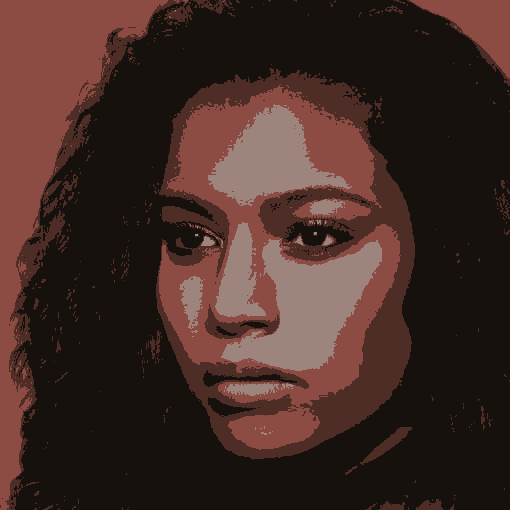

In [33]:
num_centroids = 4
a = KmeansPP(num_centroids,2)
a.fit(X)
a.plot(X)



a = KmeansPP(num_centroids,2)
a.fit(rgb)
display_image(rgb, a.return_centers())

9.   Compare 4,5,7,8. 

The results showcase the main differences between Kmeans and Kmeans++.

**Consistency:** K-means++ tends to be more consistent across different runs than the standard K-means due to its initialization process. 

**Convergence to Actual Clusters:** With the standard K-means, especially without a carefully chosen seed, the algorithm might converge to local minima that do not represent the actual clusters well. This is less of an issue with K-means++

**Effect of Seeding:** Specific seeds in standard K-means can lead to the best possible clustering (like in step 5 with seed=2), but this is not reliable. K-means++ reduces this reliance on the initial seed with smarter initilization of clusters - though this does not make it reliable in 100% percent of situations (seeds).


## Hierarchical Clustering:

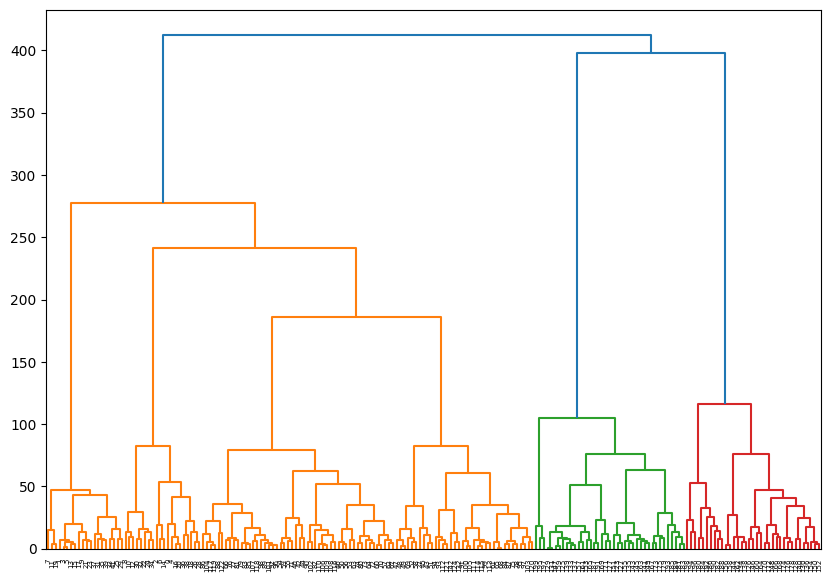

In [34]:

class Hieracrhical:
    def __init__(self) -> None:
        self.matrix = []
        self.largest_id = 0

    def initilize_clusters(self, points):
        self.clusters = {i:[i] for i in range(len(points))}
        self.largest_id = len(points)-1
        self.distances = {}
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                self.distances[(i, j)] = self.ward_distance(points, [i], [j])

    def fit(self, points):
        self.initilize_clusters(points)
        while len(self.clusters) > 1:
            cluster_pair = min(self.distances, key=self.distances.get)
            self.merge_clusters(points, cluster_pair)
            self.update_distance(points, cluster_pair)

    def merge_clusters(self, points, cluster_pair):

        cluster_0, cluster_1 = self.clusters.pop(cluster_pair[0]), self.clusters.pop(cluster_pair[1])
        self.largest_id += 1
        self.clusters[self.largest_id] = cluster_0 + cluster_1 

        distance = self.ward_distance(points, cluster_0, cluster_1)
        self.matrix.append([float(cluster_pair[0]), float(cluster_pair[1]), distance, 2])



    def update_distance(self, points, cluster_pair):
        for pair in list(self.distances.keys()):
            if cluster_pair[0] in pair or cluster_pair[1] in pair:
                del self.distances[pair]

        for c in self.clusters.keys():
            if c != self.largest_id:
                new_dist = self.ward_distance(points, self.clusters[self.largest_id], self.clusters[c])
                self.distances[(min(self.largest_id, c), max(self.largest_id, c))] = new_dist

    def ward_distance(self, points, cluster_a, cluster_b):
        points_a = points[cluster_a]
        points_b = points[cluster_b]
        points_ab = np.vstack((points_a, points_b))

        centroid_a = np.mean(points_a, axis=0)
        centroid_b = np.mean(points_b, axis=0)
        centroid_ab = np.mean(points_ab, axis=0)

        first_term = np.sum(np.linalg.norm(points_ab - centroid_ab, axis=1) ** 2)
        second_term = np.sum(np.linalg.norm(points_a - centroid_a, axis=1) ** 2)
        third_term = np.sum(np.linalg.norm(points_b - centroid_b, axis=1) ** 2)

        c = np.sqrt(2*(first_term-second_term-third_term))
        return c


Mall = pd.read_csv("Mall_Customers.csv")
mapping = {"Male":1, "Female":-1}
Mall["Gender"] = Mall["Gender"].map(mapping)
Mall = Mall.drop("CustomerID", axis=1)
points = Mall.to_numpy()

a = Hieracrhical()
a.fit(points)
m = np.array(a.matrix)
plt.figure(figsize=(10, 7))
den = sch.dendrogram(m)